# Analysis of NYC Bike Share Citi Bike Data
## by Minjian Wu

## Investigation Overview

we are motivated by a few questions, for example: Where do Citi Bikers ride? How far do they go? When are most trips taken in terms of time of day, day of the week, or month of the year? Which stations are most popular? How long does the average trip take? Does any of these depend on if a user is a subscriber or customer, a male or female, and/or some certain age?
We are going to find these out from exploration of the NYC bike share data collected for the year of 2020. We will leverage Python's visualisation libraries to help with our analyses.

## Dataset Overview

The data includes (for each month of a year):
- Trip Duration in seconds
- Start Time and Date
- Stop Time and Date
- Start Station Name
- End Station Name
- Station ID
- Station Lat/Long
- Bike ID
- User Type (Customer = 24-hour pass or 3-day pass user; Subscriber = Annual Member)
- Gender (0 = unknown; 1 = male; 2 = female)
- Year of Birth

This data has been processed to remove trips that are taken by staff as they service and inspect the system, trips that are taken to/from any of the “test” stations, and any trips that were below 60 seconds in length (potentially false starts or users trying to re-dock a bike to ensure it's secure).

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import folium

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
data = pd.read_csv('NYC_bike_2020_cleaned.csv', index_col=False)
data.drop('Unnamed: 0', axis=1, inplace=True)

In [3]:
# pre-processing / preparation
# convert time columns to datatime objects
data['starttime'] = pd.to_datetime(data['starttime'])
data['stoptime'] = pd.to_datetime(data['stoptime'])
# transform gender labels to [male, female] instead of [1,2]
data['gender'] = data['gender'].map({1: 'male', 2: 'female'})
# find the quantile min and max and return a mask for values in between
def filt_min_max(col):
    min_v = col.quantile(.25) - stats.iqr(col) * 1.5
    max_v = col.quantile(.75) + stats.iqr(col) * 1.5
    mask = col.between(min_v, max_v)
    return mask
# apply the filter to the three columns
df = data[filt_min_max(data['tripduration']) & filt_min_max(data['age'])
          & filt_min_max(data['dist stations'])]
# remove rows with same starting and ending station
df = df[df['dist stations'] != 0]

# most popular stations a bike ride starts from
top_10_stations = df['start station id'].value_counts()[:10]
# get the coordinates for the top 10 stations
co_ords = df[[
    'start station id', 'start station latitude', 'start station longitude'
]]
co_ords = co_ords[co_ords['start station id'].isin(top_10_stations.index)]
co_ords = co_ords.drop_duplicates(subset='start station id')
# top 10 destination/end of trip stations
top_10_end_stations = df['end station id'].value_counts()[:10]
# get the coordinates
co_ords_end = df[[
    'end station id', 'end station latitude', 'end station longitude'
]]
co_ords_end = co_ords_end[co_ords_end['end station id'].isin(
    top_10_end_stations.index)]
co_ords_end = co_ords_end.drop_duplicates(subset='end station id')

> Note that the above cells have been set as "Skip"-type slides. That means
that when the notebook is rendered as http slides, those cells won't show up.

## Locations for most popular start stations

Pin point the top 10 most popular bike ride start stations on a map

In [4]:
# plot the start stations on a map to visualise location
map = folium.Map(location=[40.743227, -73.974498],
                 tiles='Stamen Terrain',
                 zoom_start=13)  # zoom into NYC

# pin the top 10 popular stations on map
for i in range(0, 10):
    folium.Marker([co_ords.iloc[i, 1], co_ords.iloc[i, 2]],  # Lat/Long
                  popup='start station id: ' + str(co_ords.iloc[i, 0]),  # label with station id
                  opacity=0.7).add_to(map)
map

## Locations for most popular end stations

Pin point the top 10 most popular bike ride end stations on a map

In [5]:
# make the plot on map
map_end_stations = folium.Map(location=[40.743227, -73.974498], 
                              tiles='Stamen Terrain',
                              zoom_start=13)  # zoom into NYC

# pin the top 10 popular stations on map
for i in range(0, 10):
    folium.Marker([co_ords_end.iloc[i, 1], co_ords_end.iloc[i, 2]],  # Lat/Long
                  popup='end station id: ' + \
                  str(co_ords_end.iloc[i, 0]),  # label with station id
                  opacity=0.7).add_to(map_end_stations)
map_end_stations

So, the top start and end stations share exactly the same locations except for slightly different ranking for the top 10 destination bike stations! Since we have got rid of those trips that start and end at the same location (i.e. those with a straight line distance of zero), the coincidence that most trips still start and end between the same 10 stations indicates a true popularity for bikes at these locations - near parks and/or central. So if a company was to invest in putting more bikes or in setting up a snacks/drinks bar/mobile shop then these locations are ideal.

## Most popular month in 2020 for bike rides

What is the most common time that a bike ride takes place - which month in year 2020?

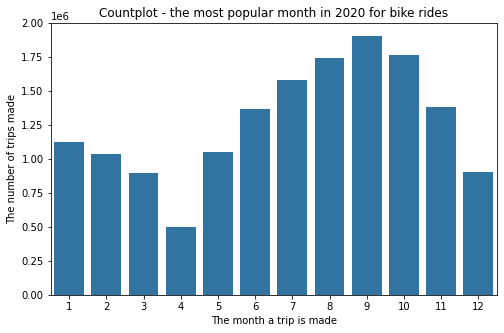

In [6]:
df['start_month'] = df['starttime'].dt.month
basic_color = sns.color_palette()[0]
plt.figure(figsize=(8, 5))
# make a countplot:
sns.countplot(data=df, x='start_month', color=basic_color)
plt.xlabel('The month a trip is made')
plt.ylabel('The number of trips made')
plt.title('Countplot - the most popular month in 2020 for bike rides');

The ride time peaks during the summer months as expected, with September being the busiest month.

## Most popular day in a month for bike rides

What is the most common time that a bike ride takes place - which day in a month?

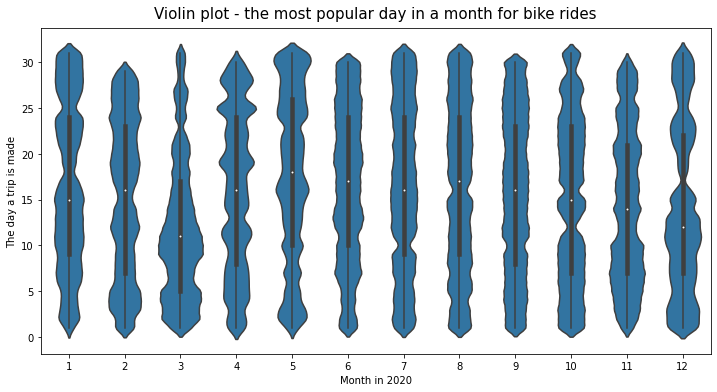

In [7]:
df['start_date'] = pd.to_numeric(df['starttime'].dt.strftime('%d'))

plt.figure(figsize=(12, 6))
base_color = sns.color_palette()[0] 
sns.violinplot(data=df, x='start_month', y='start_date', color=base_color);

plt.xlabel('Month in 2020')
plt.ylabel('The day a trip is made')
plt.title('Violin plot - the most popular day in a month for bike rides', fontsize=15, y=1.01);

There doesn't appear to be a particular pattern around the activities each day in a month. Otherwise, one observation we can make is that the number of daily bike rides almost flats out at high levels throughout August and September. One could say that throughout 2020, the first half of each month has more bike riding activities than the second half, but the difference would only be marginal.

## Most popular time in a day for bike rides

What is the most common time that a bike ride takes place - which time in a day?

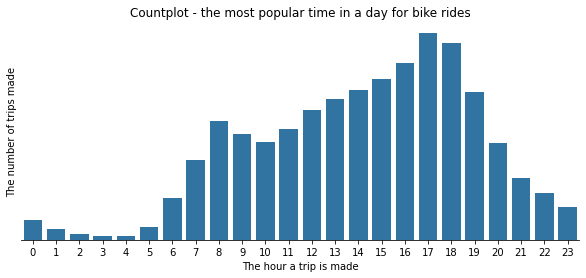

In [8]:
df['start_hour'] = df['starttime'].dt.hour

# make a countplot for the hours across all days in 2020
plt.figure(figsize=(10,4))
sns.countplot(x=df['start_hour'], color=basic_color)
plt.yticks([])
sns.despine(left=True)
plt.xlabel('The hour a trip is made')
plt.ylabel('The number of trips made')
plt.title('Countplot - the most popular time in a day for bike rides');

Within a day, bike rides usually peak at 8am and then around 5pm, with more people ride bikes in the afternoon, as bike activities drop slightly in the morning passing the peak time at 8 and pick up the pace gradually from lunchtime all the way towards late afternoon. This pattern seems to follow a typical work/social/home schedule and it is not affected by whether the day is in a warm/hot or cold month. It then follows that the peaks are likely related to people using bikes to commute between work and home.

In [9]:
# code cell
# randomly pick 1% of the whole dataset to speed up plotting
df_shorttrips = df.sample(frac=0.01, replace=False, random_state=1)

# filter for only those trips that are between two closeby stations, 
# but not limited to any trip duration
df_shorttrips = df_shorttrips[df_shorttrips['dist stations'] <= 2]

## Between-station distance vs trip duration by gender/user type

Data show that shorter distance trips do not necessarily take shorter times to complete, and we think that it is because people may make stops on the way or take detours / longer routes. Could this be linked to behaviour in a particular gender or the subscription type (24-hr/3-day pass or annual membership)?

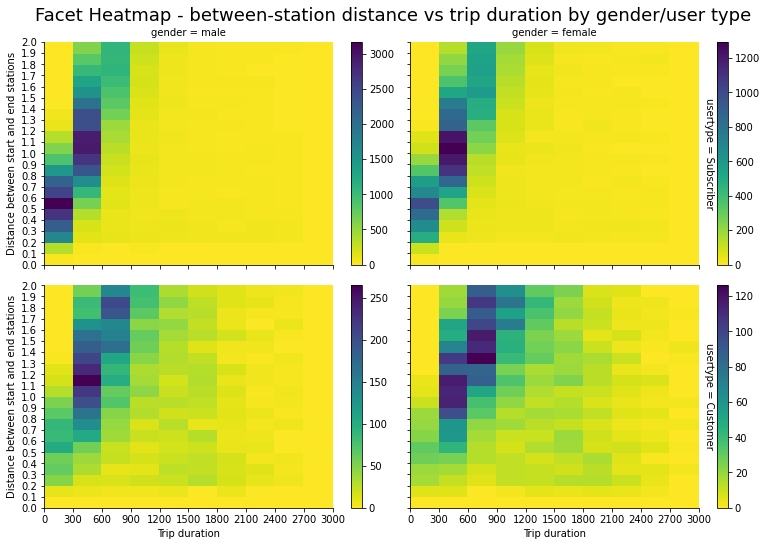

In [10]:
# Summarise the two plots above in a facet plot
g = sns.FacetGrid(data=df_shorttrips,
                  col='gender',
                  row='usertype',
                  margin_titles=True,
                  height=3.6,
                  aspect=1.5)

# map a hist2d plot each with a colorbar onto the facet
bins_x = np.arange(0, 3000 + 300, 300)  # every 5min (300s)
bins_y = np.arange(0, 2 + 0.1, 0.1)  # every 100m

def hist2d(data, color):
    plt.hist2d(data['tripduration'],
               data['dist stations'],
               cmap='viridis_r',
               bins=[bins_x, bins_y])
    plt.colorbar()

g.map_dataframe(hist2d)
g.set_axis_labels("Trip duration", "Distance between start and end stations")
g.set(xticks=bins_x, yticks=bins_y)
plt.suptitle('Facet Heatmap - between-station distance vs trip duration by gender/user type', fontsize=18, y=1.02);

More darker colours are on the right of the plots for customers (bottom row) than for subscribers (top row). This illustrates significantly fewer (in proportion) subscribers spend longer times on bike rides than customers. In other words, customer users (who are on a 24-hr or 3-day pass) tend to spend more time on their bike ride. This makes sense because customers would wish to make most use of their limited-time passes.

On the other hand, the darker colours follow a steeper line for male users (left column) than that for female users (right column), but these colours do not comparably (between male and female) occupy more areas to the right of the plots. This means that there is no tendency for women to spend more / less time on a ride than men other than due to speed of ride.

## Between-station distance vs trip duration by age

Data show that shorter distance trips do not necessarily take shorter times to complete, and we think that it is because people may make stops on the way or take detours / longer routes. Could this also be linked to behaviour in a particular age group?

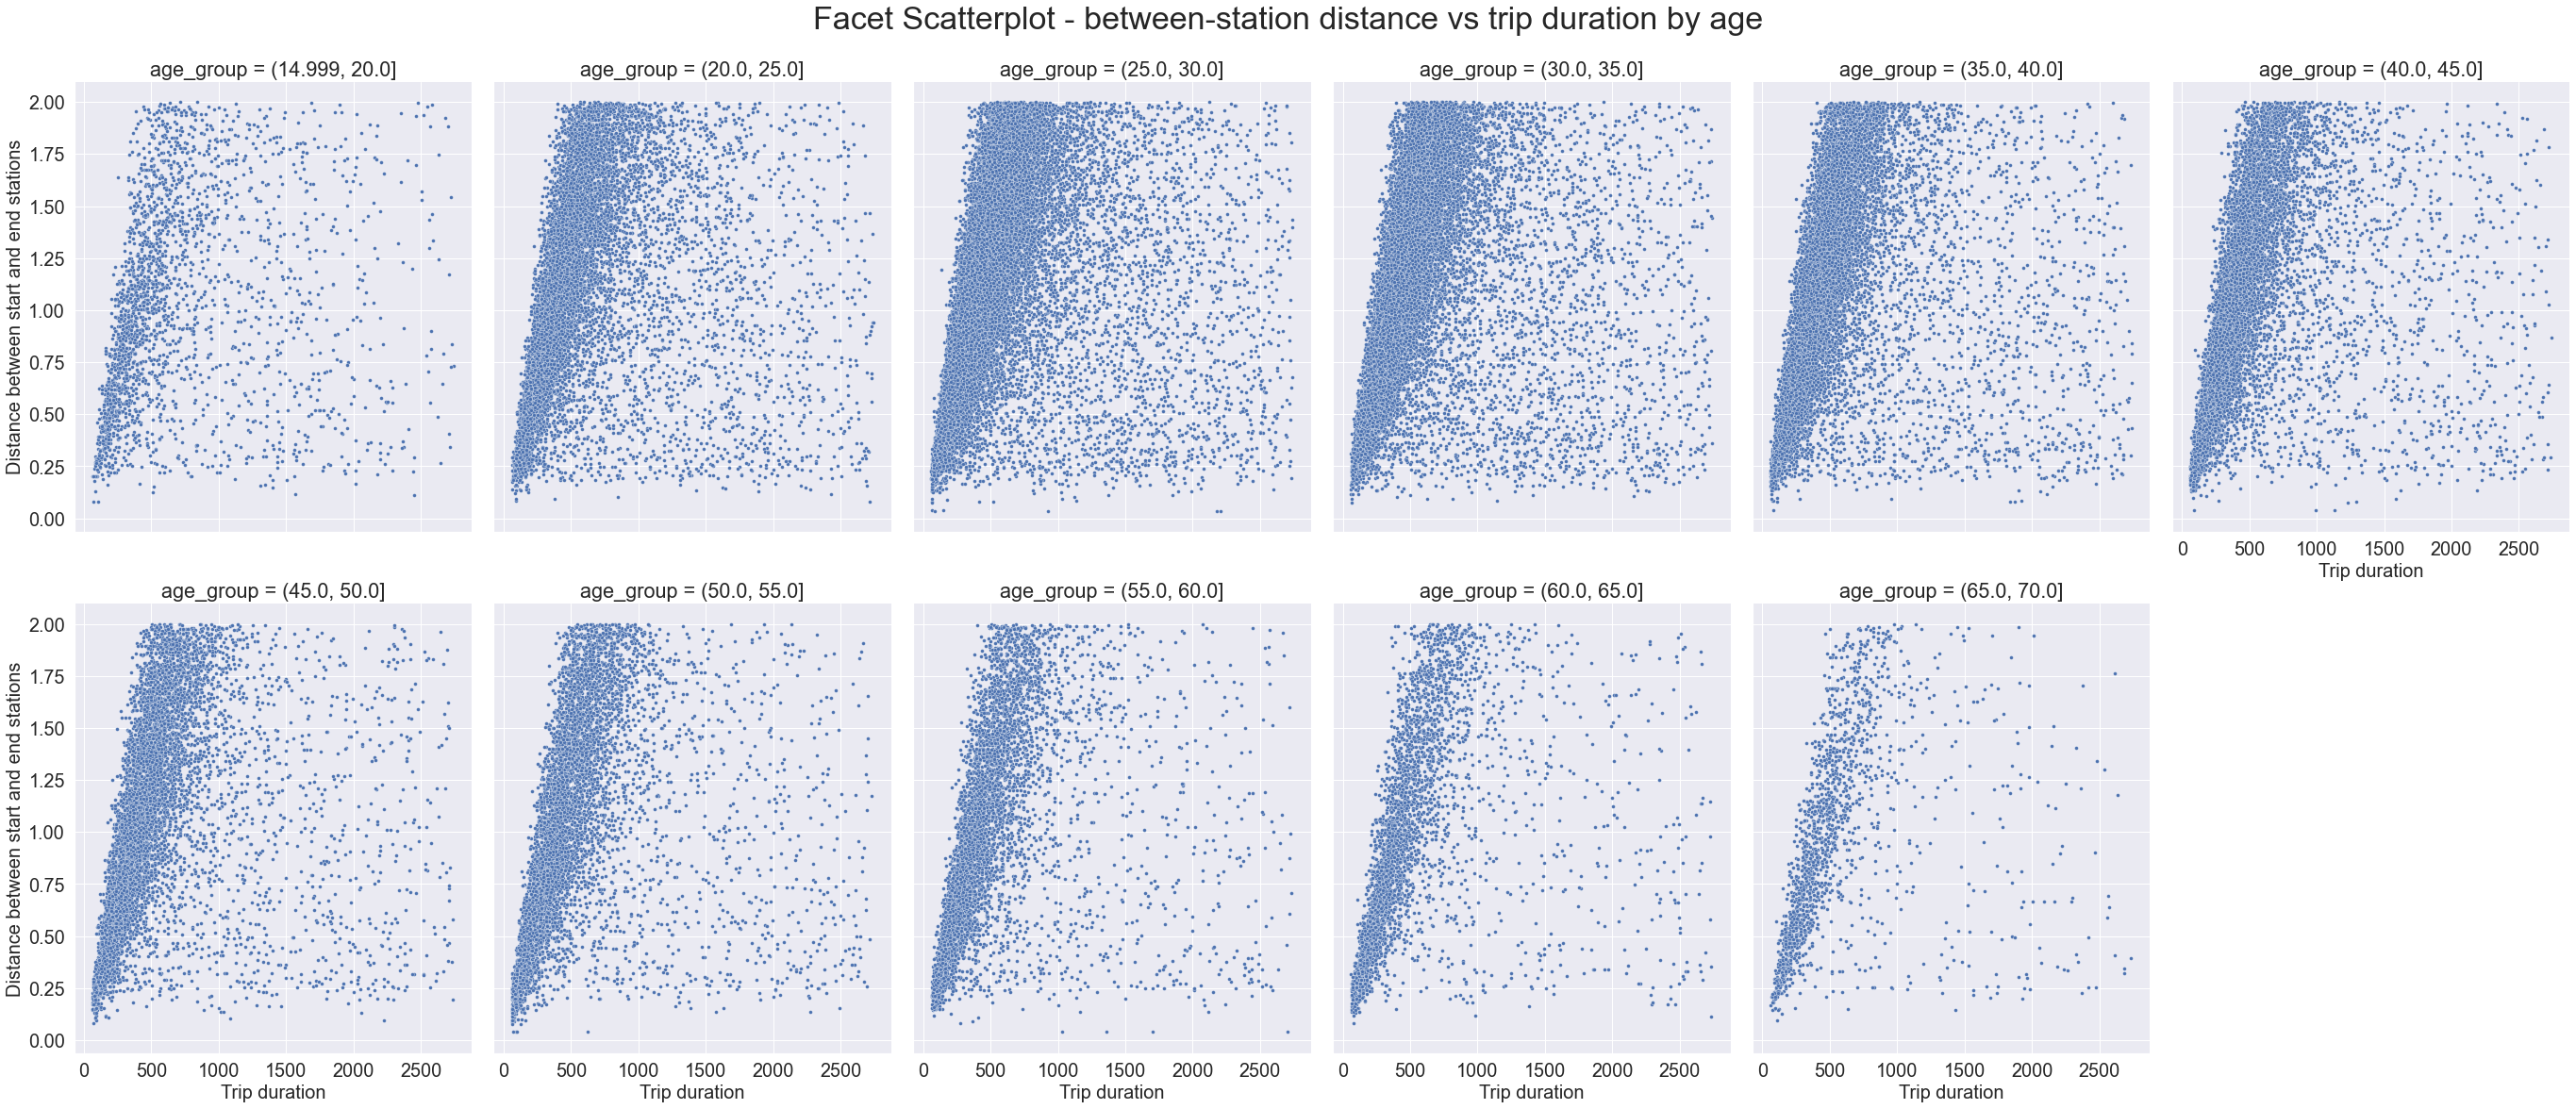

In [33]:
# due to the volume of different coloured points a scatter plot would have,
# we will facet the plots on age groups
bin_edges = np.arange(15, 70 + 5, 5)
df_shorttrips['age_group'] = pd.cut(df_shorttrips['age'],
                                    bins=bin_edges,
                                    include_lowest=True)

sns.set(font_scale=1.8)

# make a facet plot:
g = sns.FacetGrid(data=df_shorttrips,
                  col='age_group',
                  col_wrap=6,
                  height=8,
                  aspect=.8)
g.map(sns.scatterplot, 'tripduration', 'dist stations', s=15)
g.set_axis_labels("Trip duration", "Distance between start and end stations", fontsize=20)
plt.suptitle('Facet Scatterplot - between-station distance vs trip duration by age', fontsize=34, y=1.03);

There is no differential pattern associated with age - most people spend time on trips proportional to distance between stations and there is no pattern in the spread of points to the right of each plot.

The slope of the cluster on each plot indicates the average riding speed for each age group. Then obviously older people have a more gradual slope in the plots due to them riding at lower speeds.

> Once you're ready to finish your presentation, check your output by using
nbconvert to export the notebook and set up a server for the slides. From the
terminal or command line, use the following expression:
> > `jupyter nbconvert <file_name>.ipynb --to slides --post serve --template output_toggle`

> This should open a tab in your web browser where you can scroll through your
presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent
slide. Make sure you remove all of the quote-formatted guide notes like this one
before you finish your presentation!